# Lending Club Default Models

In [1]:
#Libraries
import pandas as pd
import os
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from collections import Counter
from sklearn.model_selection import train_test_split

from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

#Display settings 
display = pd.options.display
display.max_columns = 1000
display.max_rows = 1000
display.max_colwidth = 199
display.width = 1000

In [2]:
#files
dir_name = os.getcwd()
file_name = '/Loan_status_2007-2020Q3.gzip'
dir_path = dir_name+file_name

meta_name = '/LCDataDictionary.xlsx'
meta_path = dir_name+meta_name

In [3]:
metaData = pd.read_excel(meta_path, engine='openpyxl') #utf-8 reading issues; openpyxl works best

metaData.style.set_properties(subset=['Description'], **{'width': '1000px'})

In [4]:
#Read Data

loanData = pd.read_csv(dir_path, low_memory=False, index_col=0)
loanData.head()
loanData.shape

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


(2925493, 141)

In [5]:
# Encoding the `loan_status`
# status 1: 'Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'
# status 0: 'Fully Paid'
keep_status = ['Charged Off', 'Fully Paid', 'Late (16-30 days)', 'Late (31-120 days)', 'Default', 'Current']
loanData = loanData[loanData['loan_status'].isin(keep_status)]

#create a chargeoff flag
loanData['coFlag'] = 1
loanData.loc[loanData['loan_status'].isin(['Fully Paid','Late (16-30 days)','Current']), 'coFlag'] = 0

In [6]:
loanData['loan_status'].value_counts()

Fully Paid            1497783
Current               1031016
Charged Off            362548
Late (31-120 days)      16154
Late (16-30 days)        2719
Default                   433
Name: loan_status, dtype: int64

In [7]:
print(loanData.dtypes)

id                                             object
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                       object
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                                            object
purpose                     

In [8]:
loanData.head()

id  loan_amnt  funded_amnt  funded_amnt_inv        term int_rate  installment grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status pymnt_plan                                                               url         purpose                 title zip_code addr_state    dti  delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal revol_util  total_acc initial_list_status  out_prncp  out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  total_rec_int  total_rec_late_fee  recoveries  collection_recovery_fee last_pymnt_d  last_pymnt_amnt next_pymnt_d last_credit_pull_d  last_fico_range_high  last_fico_range_low  collections_12_mths_ex_med  mths_since_last_major_derog  policy_code application_type  annual_inc_joint  dti_joint verification_status_joint  acc_now_delinq  tot_coll_amt  tot_cur_bal  \
0  1077501     5000.0       5000.0           4975.0   36 months   10.65%       162.87     B        B2                       NaN  10+ years           RENT     24000.0            Verified  Dec-2011   Fully Paid          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077501     credit_card              Computer    860xx         AZ  27.65          0.0         Jan-1985           735.0            739.0             1.0                     NaN                     NaN       3.0      0.0    13648.0      83.7%        9.0                   f        0.0            0.0   5863.155187          5833.84          5000.00         863.16                0.00         0.0                     0.00     Jan-2015           171.62          NaN           May-2020                 704.0                700.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
1  1077430     2500.0       2500.0           2500.0   60 months   15.27%        59.83     C        C4                     Ryder   < 1 year           RENT     30000.0     Source Verified  Dec-2011  Charged Off          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077430             car                  bike    309xx         GA   1.00          0.0         Apr-1999           740.0            744.0             5.0                     NaN                     NaN       3.0      0.0     1687.0       9.4%        4.0                   f        0.0            0.0   1014.530000          1014.53           456.46         435.17                0.00       122.9                     1.11     Apr-2013           119.66          NaN           Oct-2016                 499.0                  0.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
2  1077175     2400.0       2400.0           2400.0   36 months   15.96%        84.33     C        C5                       NaN  10+ years           RENT     12252.0        Not Verified  Dec-2011   Fully Paid          n  https://lendingclub.com/browse/loanDetail.action?loan_id=1077175  small_business  real estate business    606xx         IL   8.72          0.0         Nov-2001           735.0            739.0             2.0                     NaN                     NaN       2.0      0.0     2956.0      98.5%       10.0                   f        0.0            0.0   3005.666844          3005.67          2400.00         605.67                0.00         0.0                     0.00     Jun-2014           649.91          NaN           Jun-2017                 739.0                735.0                         0.0                          NaN          1.0       Individual               NaN        NaN                       NaN             0.0           NaN          NaN   
3  1076863    10000.0      10000.0          10000.0 

In [9]:
#Data cleanup
loanData['int_rate'] = loanData['int_rate'].str[:-1].astype(float) #Strip off the %sign
loanData['revol_util'] = loanData['revol_util'].str[:-1].astype(float) #Strip off the %sign

loanData['emp_length'].fillna(value=-1,inplace=True)
loanData['emp_length'].replace(to_replace='< 1 year', value='0', inplace=True)
loanData['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True,regex=True)
loanData['term'] = pd.to_numeric(loanData['term'].str.replace(' months', ''))

In [10]:
#New features

#Length of credit file - thin file elimination
loanData['issue_date']  = loanData["issue_d"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['oldest_credit_date']  = loanData["earliest_cr_line"].apply(lambda x: datetime.strptime(x, "%b-%Y"))
loanData['credit_hist'] = loanData.issue_date.dt.to_period('M') - loanData.oldest_credit_date.dt.to_period('M')
loanData['credit_hist'] = loanData['credit_hist'].map(lambda x: x.n) 
#loanData[['oldest_credit_date','issue_date','credit_hist']].head()

#FICO
loanData['fico'] = (loanData['fico_range_low']+loanData['fico_range_high'])/2
loanData['refreshFico'] = (loanData['last_fico_range_low']+loanData['last_fico_range_high'])/2

#Funded Ratio
loanData['fund_ratio'] = loanData['funded_amnt'].div(loanData['loan_amnt'])


#Funded Ratio
loanData['loan_to_inc'] = loanData['funded_amnt'].div(loanData['annual_inc'])


In [11]:
#Remove temporal variables - since we want to predict propensity to default @Origination
#https://www.kaggle.com/tysonpo/columns-available-at-origination-answer

temporal_vars_remove = ['last_credit_pull_d','last_fico_range_high','last_fico_range_low','total_pymnt',
                        'total_pymnt_inv','recoveries','collection_recovery_fee','out_prncp','out_prncp_inv',
                        'total_rec_prncp','total_rec_int','last_pymnt_d','last_pymnt_amnt','next_pymnt_d',
                        'total_rec_late_fee','hardship_flag','hardship_amount',
                        'orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',
                        'hardship_last_payment_amount','debt_settlement_flag','hardship_type','hardship_reason',
                        'hardship_status','deferral_term','hardship_start_date','hardship_end_date','payment_plan_start_date',
                        'hardship_length','hardship_dpd','hardship_loan_status','installment','pymnt_plan',
                        'acc_now_delinq']

#For simplicity dropping secondary variables - using the application type - individual v/s joint
other_vars_remove  = ['url','oldest_credit_date','earliest_cr_line','last_fico_range_low','last_fico_range_high','policy_code','zip_code',
                      'sec_app_fico_range_low','sec_app_fico_range_high','sec_app_earliest_cr_line','fico_range_low', 'fico_range_high',
                     'annual_inc_joint','dti_joint','verification_status_joint', 'revol_bal_joint','sec_app_inq_last_6mths',
                     'sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
                      'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med'
                     ]

print(len(loanData.columns), len(temporal_vars_remove), len(other_vars_remove))

vars_to_remove = temporal_vars_remove + other_vars_remove

loanData.drop(vars_to_remove, axis=1, inplace=True)
#loanDataBkp = loanData.copy()

149 34 24


In [12]:
#Missing Data - we might drop these (after dropping temporal vars)
missing_percent = loanData.isnull().mean().sort_values(ascending=False)
missing_percent.head(50)

mths_since_last_record            0.853940
mths_since_recent_bc_dlq          0.777467
mths_since_last_major_derog       0.752718
mths_since_recent_revol_delinq    0.681699
mths_since_last_delinq            0.525445
il_util                           0.395960
mths_since_rcnt_il                0.317163
all_util                          0.296658
total_cu_tl                       0.296537
inq_last_12m                      0.296537
open_acc_6m                       0.296537
inq_fi                            0.296537
open_rv_24m                       0.296537
open_rv_12m                       0.296537
total_bal_il                      0.296537
open_il_24m                       0.296537
max_bal_bc                        0.296537
open_il_12m                       0.296537
open_act_il                       0.296537
mths_since_recent_inq             0.126379
emp_title                         0.090135
num_tl_120dpd_2m                  0.054478
mo_sin_old_il_acct                0.052414
bc_util    

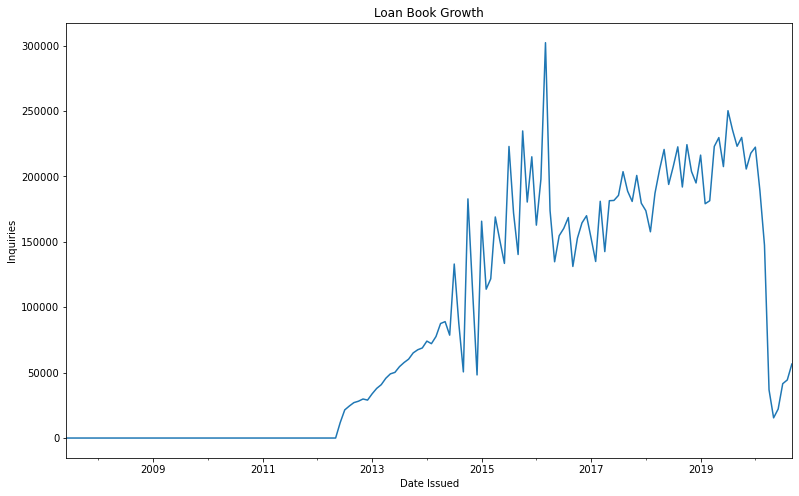

In [13]:
#The below suggests that many of the top missing variables are temporal in the collection sense
#LendingClub likely did not use the missing variables prior to 
grouped = loanData.groupby(by=['issue_date'])
grouped_agg = (grouped['num_bc_sats']
               .agg(np.sum)
               .rename('Inquiries'))
grouped_agg_df = grouped_agg.reset_index()
grouped_agg_ts = pd.Series(data=grouped_agg_df['Inquiries'].values,
                           index=grouped_agg_df['issue_date'])
del grouped_agg_df

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111)
grouped_agg_ts.plot(ax=ax)
ax.set_xlabel('Date Issued')
ax.set_ylabel('Inquiries')
ax.set_title('Loan Book Growth')
plt.show()

In [14]:
loanData.head()

id  loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate grade sub_grade                 emp_title emp_length home_ownership  annual_inc verification_status   issue_d  loan_status         purpose                 title addr_state    dti  delinq_2yrs  inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med  mths_since_last_major_derog application_type  tot_coll_amt  tot_cur_bal  open_acc_6m  open_act_il  open_il_12m  open_il_24m  mths_since_rcnt_il  total_bal_il  il_util  open_rv_12m  open_rv_24m  max_bal_bc  all_util  total_rev_hi_lim  inq_fi  total_cu_tl  inq_last_12m  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  bc_util  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_il_acct  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  mths_since_recent_bc_dlq  mths_since_recent_inq  mths_since_recent_revol_delinq  \
0  1077501     5000.0       5000.0           4975.0    36     10.65     B        B2                       NaN         10           RENT     24000.0            Verified  Dec-2011   Fully Paid     credit_card              Computer         AZ  27.65          0.0             1.0                     NaN                     NaN       3.0      0.0    13648.0        83.7        9.0                   f                         0.0                          NaN       Individual           NaN          NaN          NaN          NaN          NaN          NaN                 NaN           NaN      NaN          NaN          NaN         NaN       NaN               NaN     NaN          NaN           NaN                   NaN          NaN             NaN      NaN                       0.0          0.0                 NaN                   NaN                    NaN             NaN       NaN                   NaN                       NaN                    NaN                             NaN   
1  1077430     2500.0       2500.0           2500.0    60     15.27     C        C4                     Ryder          0           RENT     30000.0     Source Verified  Dec-2011  Charged Off             car                  bike         GA   1.00          0.0             5.0                     NaN                     NaN       3.0      0.0     1687.0         9.4        4.0                   f                         0.0                          NaN       Individual           NaN          NaN          NaN          NaN          NaN          NaN                 NaN           NaN      NaN          NaN          NaN         NaN       NaN               NaN     NaN          NaN           NaN                   NaN          NaN             NaN      NaN                       0.0          0.0                 NaN                   NaN                    NaN             NaN       NaN                   NaN                       NaN                    NaN                             NaN   
2  1077175     2400.0       2400.0           2400.0    36     15.96     C        C5                       NaN         10           RENT     12252.0        Not Verified  Dec-2011   Fully Paid  small_business  real estate business         IL   8.72          0.0             2.0                     NaN                     NaN       2.0      0.0     2956.0        98.5       10.0                   f                         0.0                          NaN       Individual           NaN          NaN          NaN          NaN          NaN          NaN                 NaN           NaN      NaN          NaN          NaN         NaN       NaN               NaN     NaN          NaN           NaN                   NaN          NaN             NaN      NaN                       0.0          0.0                 NaN                   NaN                    NaN             NaN       NaN                   NaN                       NaN                    NaN                             NaN   
3  1076863    10000.0      10000.0          1000

In [12]:
#loanDataBkp = loanData.copy()

In [15]:
drop_missing = list(missing_percent.head(25).index)
drop_missing

['mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'mths_since_last_delinq',
 'il_util',
 'mths_since_rcnt_il',
 'all_util',
 'total_cu_tl',
 'inq_last_12m',
 'open_acc_6m',
 'inq_fi',
 'open_rv_24m',
 'open_rv_12m',
 'total_bal_il',
 'open_il_24m',
 'max_bal_bc',
 'open_il_12m',
 'open_act_il',
 'mths_since_recent_inq',
 'emp_title',
 'num_tl_120dpd_2m',
 'mo_sin_old_il_acct',
 'bc_util',
 'percent_bc_gt_75']

In [16]:
loanData.drop(drop_missing, axis=1, inplace=True)

In [29]:
#Will also drop state, title, sub-grade - creating dummies for every state will blow up the dataset
drop_cat = ['addr_state','title','sub_grade']
loanData.drop(drop_cat, axis=1, inplace=True)

In [28]:
loanData.groupby(['grade']).size()

grade
A    653610
B    854288
C    798085
D    413229
E    138025
F     41463
G     11953
dtype: int64

In [30]:
# define categorical and numerical features
cat_features = ['term', 'home_ownership', 'verification_status', 'purpose', 
                'initial_list_status', 'application_type', 
                'grade'] #, 'addr_state','sub_grade']

num_features = ['loan_amnt', 'int_rate','loan_to_inc', 'emp_length', 
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 
                'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 
                'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
                'inq_last_6mths','mths_since_last_delinq',
                'open_acc_6m','open_act_il','open_il_12m','open_il_24m','mths_since_rcnt_il',
                'total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi',
                'total_cu_tl','inq_last_12m','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
                'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','mths_since_last_major_derog',
                'total_il_high_credit_limit', 'credit_hist','fund_ratio','fico','refreshFico']

num_features = [x for x in num_features if x not in drop_missing]

yVar = ['coFlag']

In [31]:
len(num_features)

52

In [32]:
#More Data cleanup

loanData[num_features] = loanData[num_features].astype(float)

loanData.replace([np.inf, -np.inf], np.nan,inplace=True)

loanData.replace(np.nan,0,inplace=True)

In [33]:
#loanData.groupby(['issue_date','coFlag'])['coFlag'].count()

In [34]:
loanData.head()

id  loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate grade  emp_length home_ownership  annual_inc verification_status   issue_d  loan_status         purpose    dti  delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med application_type  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  coFlag issue_date  credit_hist   fico  refreshFico  fund_ratio  loan_to_inc
0  1077501     5000.0       5000.0           4975.0    36     10.65     B        10.0           RENT     24000.0            Verified  Dec-2011   Fully Paid     credit_card  27.65          0.0             1.0       3.0      0.0    13648.0        83.7        9.0                   f                         0.0       Individual           0.0          0.0               0.0                   0.0          0.0             0.0                       0.0          0.0                   0.0                    0.0             0.0       0.0                   0.0                    0.0             0.0              0.0          0.0        0.0        0.0            0.0            0.0                  0.0       0.0           0.0                 0.0                 0.0             0.0                   0.0        0.0              0.0                0.0             0.0                         0.0       0 2011-12-01        323.0  737.0        702.0         1.0     0.208333
1  1077430     2500.0       2500.0           2500.0    60     15.27     C         0.0           RENT     30000.0     Source Verified  Dec-2011  Charged Off             car   1.00          0.0             5.0       3.0      0.0     1687.0         9.4        4.0                   f                         0.0       Individual           0.0          0.0               0.0                   0.0          0.0             0.0                       0.0          0.0                   0.0                    0.0             0.0       0.0                   0.0                    0.0             0.0              0.0          0.0        0.0        0.0            0.0            0.0                  0.0       0.0           0.0                 0.0                 0.0             0.0                   0.0        0.0              0.0                0.0             0.0                         0.0       1 2011-12-01        152.0  742.0        249.5         1.0     0.083333
2  1077175     2400.0       2400.0           2400.0    36     15.96     C        10.0           RENT     12252.0        Not Verified  Dec-2011   Fully Paid  small_business   8.72          0.0             2.0       2.0      0.0     2956.0        98.5       10.0                   f                         0.0       Individual           0.0          0.0               0.0                   0.0          0.0             0.0                       0.0          0.0                   0.0                    0.0             0.0       0.0                   0.0                    0.0             0.0              0.0          0.0        0.0        0.0            0.0            0.0                  0.0       0.0           0.0                 0.0                 0.0             0.0                   0.0        0.0              0.0                0.0             0.0                         0.0       0 2011-12-01        121.0  737.0        737.0         1.0     0.195886
3  1076863    10000.0      10000.0          10000.0    36     13.49     C        10.0           RENT     49200.0     Source Verified  Dec-2011  

In [35]:
# split into train test and holdout sets
loanData_test_train = loanData[loanData.issue_date <= '2019-09-01']
holdOut = loanData[loanData.issue_date > '2019-09-01'] #Out of time holdout

devSet, holdOutAdd  = train_test_split(loanData_test_train, test_size=0.03, random_state=693)#In sample holdout

holdOut = holdOut.append(holdOutAdd) #In + Out sample holdout

trainSet, testSet = train_test_split(devSet,test_size=0.3, random_state=693) #test and train splits

devSet.reset_index(inplace=True)
trainSet.reset_index(inplace=True)
testSet.reset_index(inplace=True)
holdOut.reset_index(inplace=True)

devSet.drop('index', axis=1, inplace=True)

print(len(loanData.index),len(trainSet.index), len(testSet.index), len(holdOut.index))

print(holdOut['coFlag'].value_counts())

#dupRows = loanData[loanData.duplicated()]
#print(len(dupRows))

2910653 1792074 768033 350546
0    336891
1     13655
Name: coFlag, dtype: int64


/Users/arun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [36]:
#loanData['issue_d'].value_counts()

In [37]:
loanData.columns.values

array(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'collections_12_mths_ex_med', 'application_type', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths',
       'avg_cur_bal', 'bc_open_to_buy', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'pub_rec_bankruptcies', 'ta

In [38]:
loanData[loanData.funded_amnt!=loanData.loan_amnt].tail()

id  loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate grade  emp_length home_ownership  annual_inc verification_status   issue_d loan_status             purpose    dti  delinq_2yrs  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  total_acc initial_list_status  collections_12_mths_ex_med application_type  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  coFlag issue_date  credit_hist   fico  refreshFico  fund_ratio  loan_to_inc
188174   1062334    20000.0      12675.0          12675.0    60     14.27     C        10.0       MORTGAGE     60000.0     Source Verified  Jan-2012  Fully Paid  debt_consolidation  16.64          0.0             0.0      12.0      0.0    18539.0        84.3       26.0                   f                         0.0       Individual           0.0          0.0               0.0                   0.0          0.0             0.0                       0.0          0.0                   0.0                    0.0             0.0       0.0                   0.0                    0.0             0.0              0.0          0.0        0.0        0.0            0.0            0.0                  0.0       0.0           0.0                 0.0                 0.0             0.0                   0.0        0.0              0.0                0.0             0.0                         0.0       0 2012-01-01        216.0  712.0        702.0    0.633750     0.211250
188180   1058291    12000.0       7775.0           7775.0    60     15.27     C         7.0           RENT     50000.0            Verified  Jan-2012  Fully Paid         credit_card   5.50          0.0             1.0      13.0      0.0     7008.0        37.9       25.0                   f                         0.0       Individual           0.0          0.0               0.0                   0.0          0.0             0.0                       0.0          0.0                   0.0                    0.0             0.0       0.0                   0.0                    0.0             0.0              0.0          0.0        0.0        0.0            0.0            0.0                  0.0       0.0           0.0                 0.0                 0.0             0.0                   0.0        0.0              0.0                0.0             0.0                         0.0       0 2012-01-01        107.0  717.0        567.0    0.647917     0.155500
32403   80749289    18000.0      10000.0          10000.0    36     12.99     C         6.0           RENT     60000.0     Source Verified  Jun-2016  Fully Paid      small_business  20.45          0.0             1.0       9.0      0.0    15537.0        43.4       12.0                   w                         0.0       Individual         155.0      28657.0           35800.0                   1.0       3184.0         19046.0                       0.0          0.0                  90.0                    4.0             4.0       0.0                  43.0                    0.0             4.0              5.0          5.0        6.0        2.0            7.0            9.0                  5.0       9.0           0.0                 0.0                 1.0           100.0                   0.0        0.0          56761.0            28657.0         31600.0                     20045.0       0 2016-06-01         91.0  687.0        712.0    0.555556     0.166667
32441   79101538    20000.0      10000.0          10000.0    36      7.39     A        10.0       MORTGAGE     550

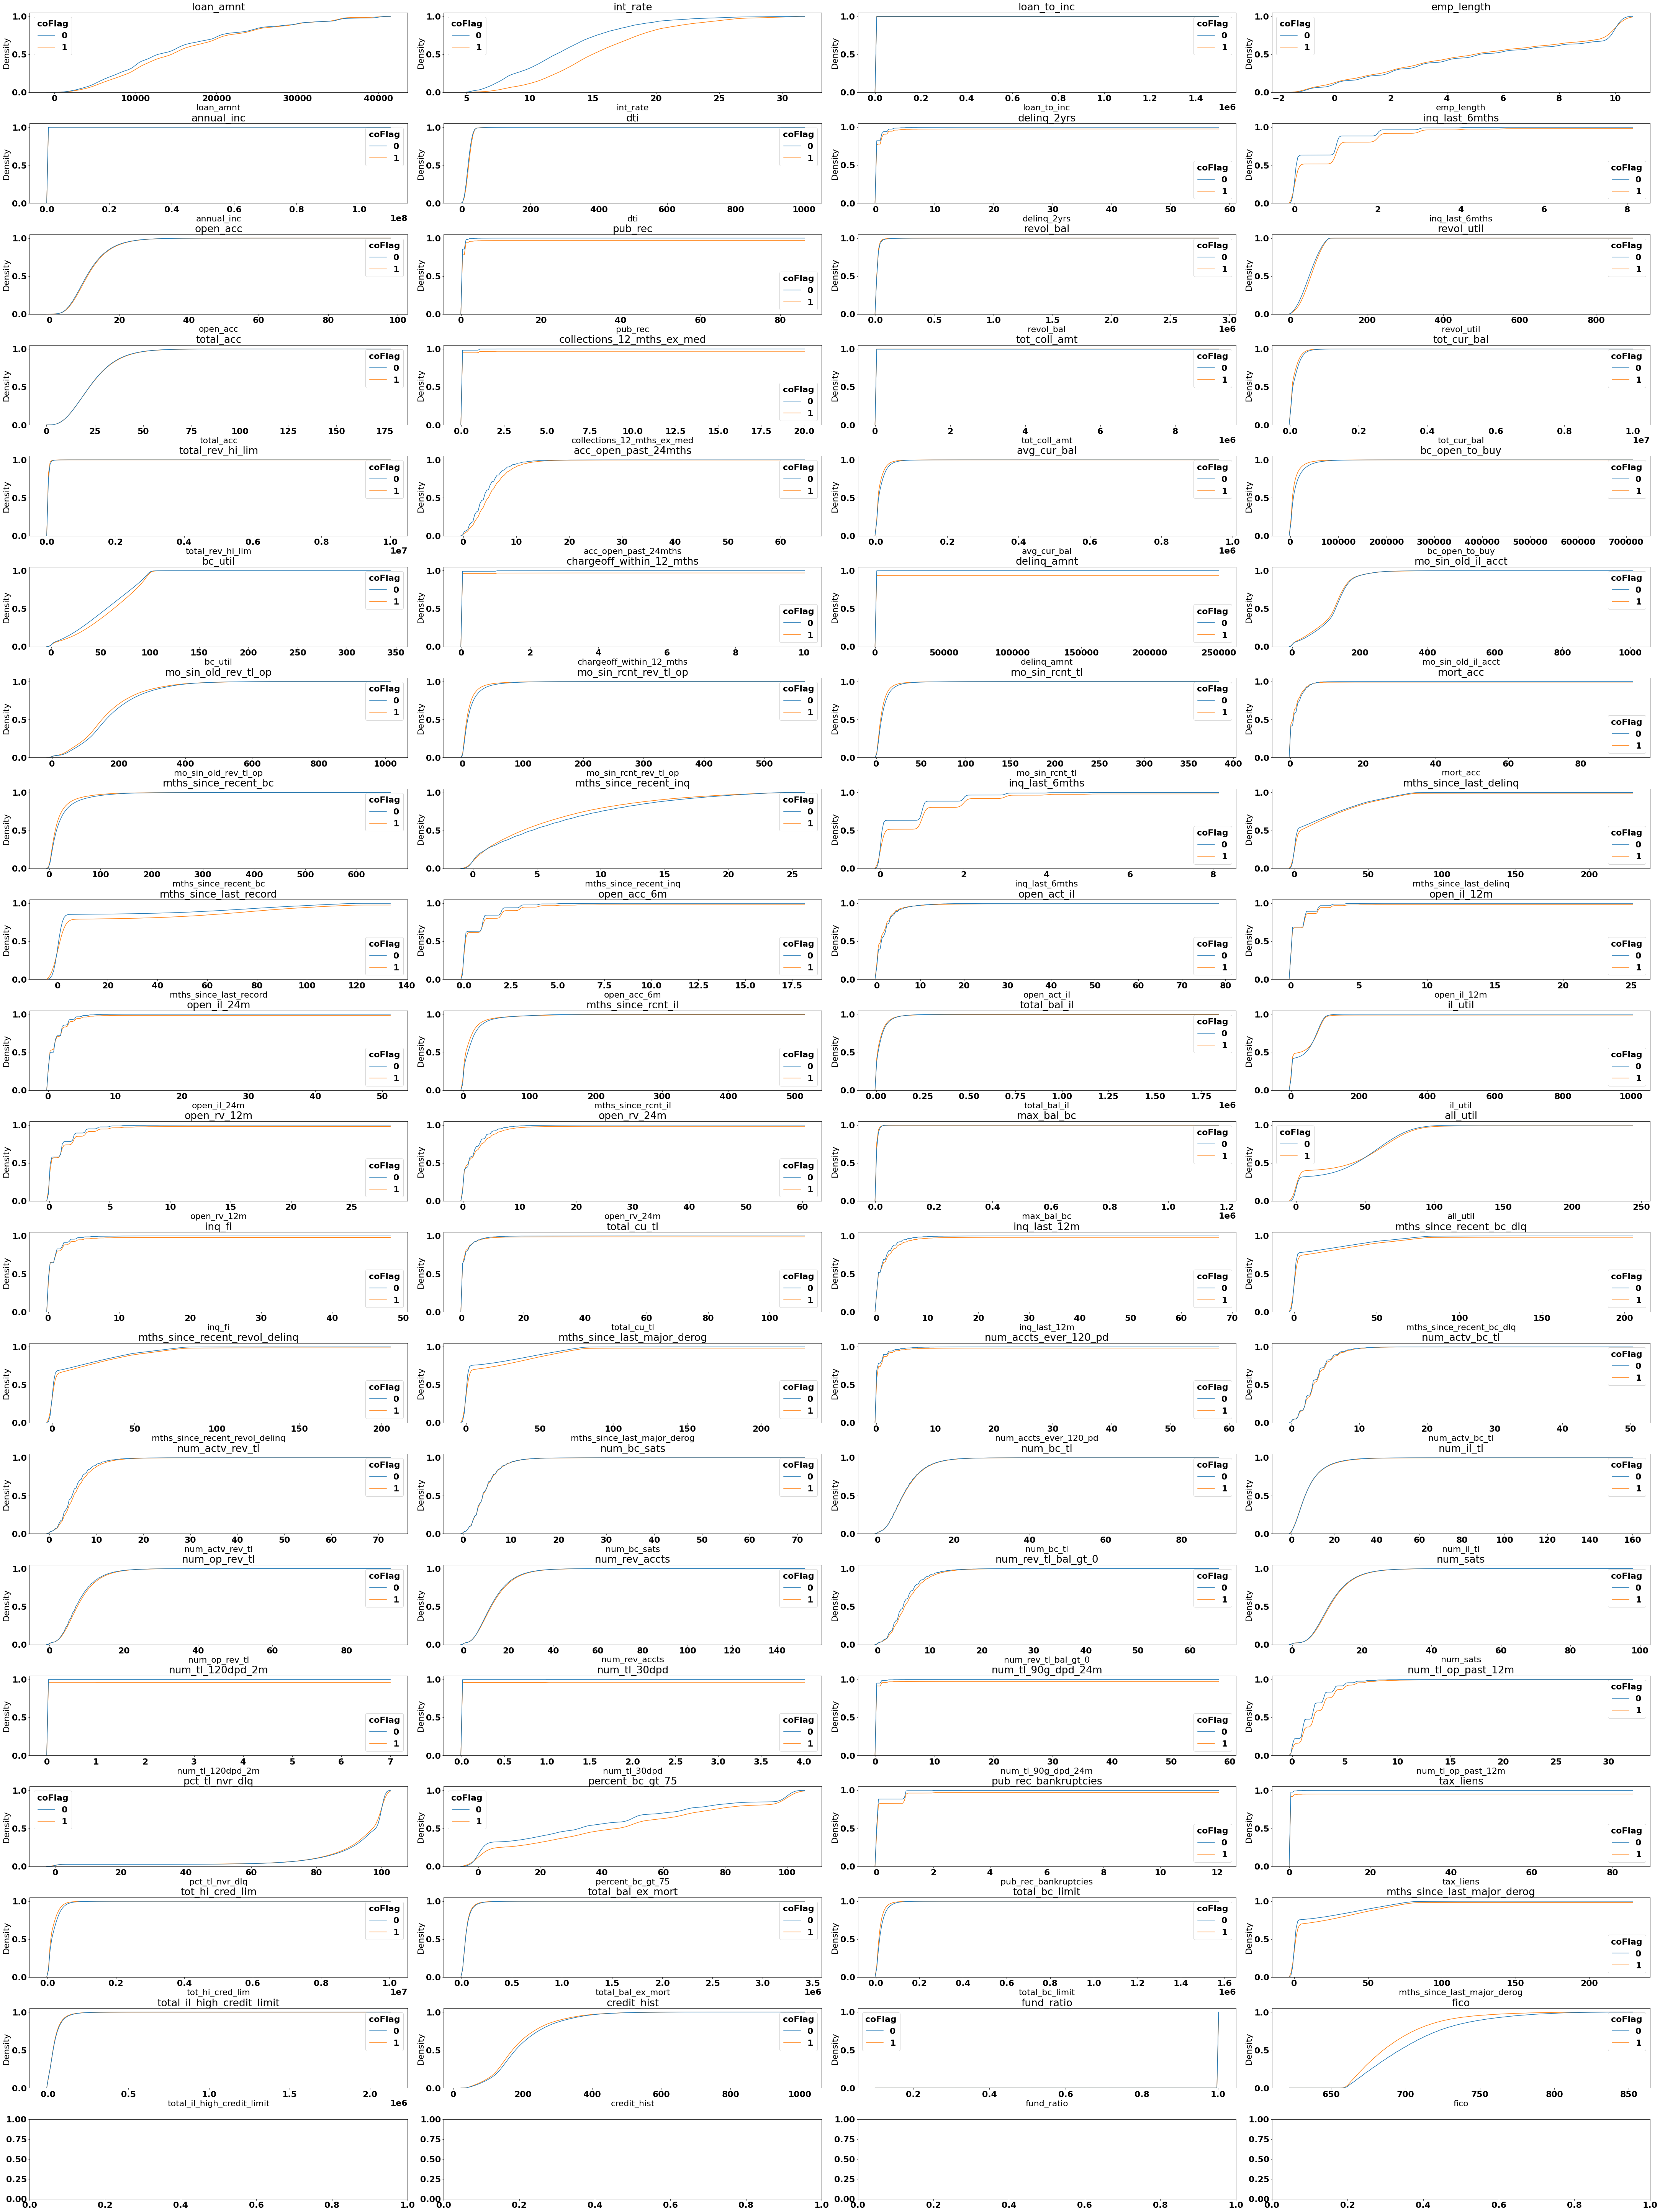

In [49]:
keep_vars = num_features


font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

#keep_vars = ['loan_amnt','int_rate','emp_length', 'mort_acc', 'mths_since_recent_bc', 
#             'mths_since_recent_inq','total_il_high_credit_limit', 'credit_hist']

colNum =0
ncols = 4
nrows = 20
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40, 120))
for row in range(0,nrows):
    for col in range(0,ncols):
            if(colNum < len(keep_vars)-1):
                sns.kdeplot(data=devSet, x = devSet[keep_vars[colNum]], hue="coFlag",cumulative=True,common_norm=False, common_grid=True,ax=axes[row, col])
                axes[row, col].set_title(keep_vars[colNum])
                colNum = colNum+1
                
fig.tight_layout(pad=0, h_pad=.15, w_pad=.15)

In [39]:
len(num_features)

52

In [21]:
#sns.pairplot(loanData[['fund_ratio','coFlag']], hue="coFlag", height=2.5)
#sns.kdeplot(data=loanData, x="credit_hist", hue="coFlag",cumulative=True, common_norm=False,common_grid=True)

In [ ]:
colNum = 0
fig, axes = plt.subplots(figsize=(6, 6), ncols=4, nrows=7)
for row in range(0, 7):
    for col in range(0, 4):
        if (colNum < len(keep_vars)-1):
            axes[row, col].scatter(loanData['coFlag'], loanData[keep_vars[colNum]])
            axes[row, col].set_xlabel(keep_vars[colNum])
            axes[row, col].set_title(keep_vars[colNum])
            colNum = colNum + 1


In [ ]:
#Correlation Matrix
corrMatrix = devSet.corr()
y = loanData['coFlag']
correl_vars = ['loan_amnt','loan_to_inc','int_rate','emp_length', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq','total_il_high_credit_limit', 'credit_length']

sns.set(style="white")
df = devSet[correl_vars]
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

g = sns.PairGrid(df, palette=["red"])
g.map_upper(plt.scatter, hue="coFlag", , palette="Set2", s=10)
g.map_diag(sns.distplot, kde=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_lower(corrfunc)

In [40]:
#Correlation Matrix
corrMatrix = devSet.corr()
matrix = np.triu(corrMatrix)
corrMatrix

loan_amnt  funded_amnt  funded_amnt_inv      term  int_rate  emp_length  annual_inc       dti  delinq_2yrs  inq_last_6mths  open_acc   pub_rec  revol_bal  revol_util  total_acc  collections_12_mths_ex_med  tot_coll_amt  tot_cur_bal  total_rev_hi_lim  acc_open_past_24mths  avg_cur_bal  bc_open_to_buy  chargeoff_within_12_mths  delinq_amnt  mo_sin_old_rev_tl_op  mo_sin_rcnt_rev_tl_op  mo_sin_rcnt_tl  mort_acc  mths_since_recent_bc  num_accts_ever_120_pd  num_actv_bc_tl  num_actv_rev_tl  num_bc_sats  num_bc_tl  num_il_tl  num_op_rev_tl  num_rev_accts  num_rev_tl_bal_gt_0  num_sats  num_tl_30dpd  num_tl_90g_dpd_24m  num_tl_op_past_12m  pct_tl_nvr_dlq  pub_rec_bankruptcies  tax_liens  tot_hi_cred_lim  total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit    coFlag  credit_hist      fico  refreshFico  fund_ratio  loan_to_inc
loan_amnt                    1.000000     0.999809         0.999366  0.392888  0.076005    0.099557    0.197150  0.049571    -0.013100       -0.030434  0.180408 -0.061045   0.322094    0.096614   0.194919                   -0.022979     -0.004653     0.309256          0.335679              0.004508     0.226887        0.213958                 -0.005524     0.000331              0.170215               0.060024        0.038345  0.217901              0.044075              -0.052179        0.196861         0.155442     0.216603   0.195420   0.091283       0.167034       0.164793             0.155326  0.185010      0.000060           -0.022735           -0.019235        0.094651             -0.080990   0.004136         0.335464           0.279512        0.374935                    0.214660  0.029979     0.156229  0.113253     0.079711   -0.010458     0.000493
funded_amnt                  0.999809     1.000000         0.999596  0.392575  0.076020    0.099562    0.197124  0.049730    -0.013019       -0.030611  0.180538 -0.060937   0.322048    0.096646   0.194843                   -0.022928     -0.004641     0.309695          0.336154              0.005119     0.227285        0.214297                 -0.005488     0.000339              0.171030               0.060387        0.038750  0.218286              0.044412              -0.052026        0.197568         0.156177     0.217301   0.196153   0.091798       0.167807       0.165558             0.156071  0.185893      0.000081           -0.022666           -0.018746        0.097051             -0.080893   0.004189         0.335950           0.279994        0.375433                    0.215119  0.029926     0.156261  0.112914     0.079644    0.007632     0.000493
funded_amnt_inv              0.999366     0.999596         1.000000  0.392811  0.076108    0.099733    0.197044  0.050080    -0.012919       -0.031178  0.180705 -0.060721   0.321878    0.096639   0.194791                   -0.022823     -0.004616     0.310392          0.336909              0.006323     0.227953        0.214889                 -0.005426     0.000346              0.172557               0.061097        0.039552  0.218919              0.045079              -0.051703        0.198842         0.157520     0.218574   0.197465   0.092774       0.169236       0.166956             0.157437  0.187556      0.000109           -0.022529           -0.017768        0.101826             -0.080655   0.004267         0.336730           0.280791        0.376222                    0.215912  0.029653     0.156527  0.112580     0.079625    0.010123     0.000494
term                         0.392888     0.392575         0.392811  1.000000  0.353518    0.068557    0.035661  0.056732    -0.013382       -0.003178  0.073641 -0.018108   0.083414    0.059300   0.093984                   -0.011360     -0.002421     0.112734          0.074006              0.025081     0.085829        0.024190                 -0.003681    -0.001060              0.050556               0.022504       -0.002664  0.103688              0.022854              -0.019506        0.050955         0.055339     0.051251   0.045520   0.077134       0.

In [63]:
fig, ax = plt.subplots(figsize=(160,200)) #figsize in inches
hmp = sns.heatmap(corrMatrix,annot=True, fmt = "0.2f", cmap = "coolwarm",ax=ax, mask=matrix,annot_kws={"size":40},
           vmin=corrMatrix.values.min(), vmax=1)

x = hmp.set_yticklabels(hmp.get_ymajorticklabels(), fontsize = 36, rotation=180)
y = hmp.set_xticklabels(hmp.get_xmajorticklabels(), fontsize = 36, rotation=90)

In [41]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in cat_features:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(trainSet['coFlag'], trainSet[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(p)

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
print(chi2_result)

               Feature        p-value
0                 term   0.000000e+00
1       home_ownership   0.000000e+00
2  verification_status   0.000000e+00
3              purpose   0.000000e+00
4  initial_list_status   0.000000e+00
5                grade   0.000000e+00
6     application_type  3.910550e-274


In [ ]:
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
                                     'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)

# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

# save the names of columns to be dropped in a list
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

# function to drop these columns
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)

In [ ]:
# Kruskal Wallis test - didn't run
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mstats
# seed the random number generator
seed(1)

# compare samples
for var in num_features:
    H, pval = mstats.kruskalwallis((devSetv[devSetv['coFlag']==1][var].values), (devSetv[devSetv['coFlag']==0][var].values))
    alpha = 0.01

    #print("H-statistic:\t%s\nP-value:\t%s" % (str(H),str(pval)))
    if str(pval) < alpha:
        print(var)
        
mstats.kruskalwallis((trainSet[trainSet['coFlag']==1]['max_bal_bc'].values), (trainSet[trainSet['coFlag']==0]['max_bal_bc'].values))

In [42]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our categorical variables
devSet = dummy_creation(devSet, cat_features)
trainSet = dummy_creation(trainSet, cat_features)

# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
trainSet = trainSet.reindex(labels=trainSet.columns, axis=1, fill_value=0)

In [44]:
# function to calculate WoE and IV of categorical features
# The function takes 3 arguments: a dataframe (X_train_prepr), a string (column name), and a dataframe (y_train_prepr).
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# We set the default style of the graphs to the seaborn style. 
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

/Users/arun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/arun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:2001: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


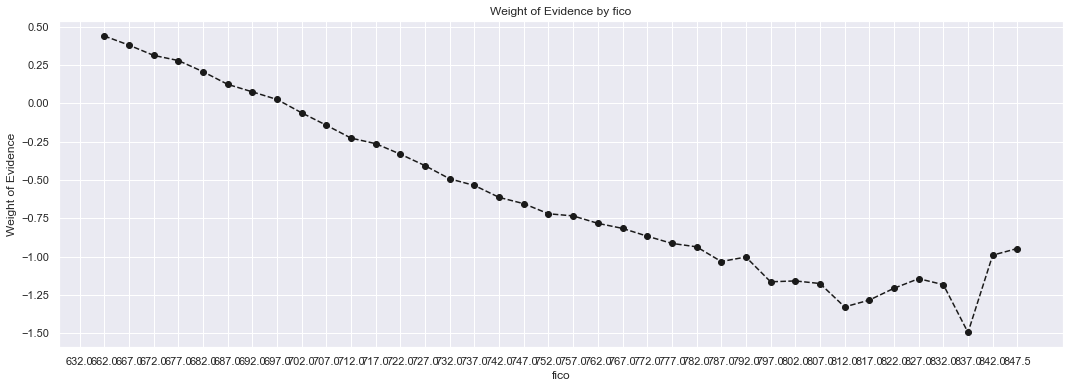

In [48]:
plot_by_woe(woe_ordered_continuous(trainSet, 'fico', trainSet['coFlag']))

In [ ]:
# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	